In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from typing import Tuple, Optional
import warnings

warnings.filterwarnings("ignore")


class MatrixFactorizationSGD:
    """
    Matrix Factorization cho Collaborative Filtering sử dụng Stochastic Gradient Descent

    Fixed version với:
    - Đúng cách tính regularization loss
    - Train/test split proper
    - Better convergence monitoring
    """

    def __init__(
        self,
        n_factors: int = 50,
        learning_rate: float = 0.01,
        regularization: float = 0.01,
        n_epochs: int = 100,
        bias: bool = True,
        verbose: bool = True,
        random_state: Optional[int] = None,
    ):
        """
        Khởi tạo Matrix Factorization model với SGD

        Parameters:
        -----------
        n_factors : int, default=50
            Số lượng latent factors (chiều của embedding vectors)
        learning_rate : float, default=0.01
            Learning rate cho SGD
        regularization : float, default=0.01
            L2 regularization coefficient (lambda)
        n_epochs : int, default=100
            Số epochs huấn luyện
        bias : bool, default=True
            Có sử dụng user và item biases hay không
        verbose : bool, default=True
            In thông tin trong quá trình huấn luyện
        random_state : int, optional
            Random seed để reproducible results
        """
        self.n_factors = n_factors
        self.learning_rate = learning_rate
        self.regularization = regularization
        self.n_epochs = n_epochs
        self.bias = bias
        self.verbose = verbose
        self.random_state = random_state

        # Model parameters
        self.user_factors = None
        self.item_factors = None
        self.user_bias = None
        self.item_bias = None
        self.global_bias = None

        # Mapping từ original IDs sang internal indices
        self.user_mapping = {}
        self.item_mapping = {}
        self.reverse_user_mapping = {}
        self.reverse_item_mapping = {}

        # Training history
        self.train_losses = []
        self.val_losses = []

        if random_state is not None:
            np.random.seed(random_state)

    def _create_mappings(self, user_ids: np.ndarray, item_ids: np.ndarray):
        """Tạo mapping từ original IDs sang internal indices"""
        unique_users = np.unique(user_ids)
        unique_items = np.unique(item_ids)

        self.user_mapping = {user_id: idx for idx, user_id in enumerate(unique_users)}
        self.item_mapping = {item_id: idx for idx, item_id in enumerate(unique_items)}

        self.reverse_user_mapping = {
            idx: user_id for user_id, idx in self.user_mapping.items()
        }
        self.reverse_item_mapping = {
            idx: item_id for item_id, idx in self.item_mapping.items()
        }

        self.n_users = len(unique_users)
        self.n_items = len(unique_items)

    def _initialize_parameters(self):
        """Khởi tạo parameters"""
        std = 0.1 / np.sqrt(self.n_factors)
        self.user_factors = np.random.normal(0, std, (self.n_users, self.n_factors))
        self.item_factors = np.random.normal(0, std, (self.n_items, self.n_factors))

        if self.bias:
            self.user_bias = np.zeros(self.n_users)
            self.item_bias = np.zeros(self.n_items)

    def _predict_single(self, user_idx: int, item_idx: int) -> float:
        """Predict rating cho một cặp user-item"""
        prediction = self.global_bias

        if self.bias:
            prediction += self.user_bias[user_idx] + self.item_bias[item_idx]

        prediction += np.dot(self.user_factors[user_idx], self.item_factors[item_idx])
        return prediction

    def _compute_loss(
        self, user_indices: np.ndarray, item_indices: np.ndarray, ratings: np.ndarray
    ) -> float:
        """
        FIXED: Tính regularized loss function đúng cách
        Chỉ regularize trên những factors được sử dụng trong batch hiện tại
        """
        predictions = np.array(
            [self._predict_single(u, i) for u, i in zip(user_indices, item_indices)]
        )

        # Squared error
        mse_loss = np.mean((ratings - predictions) ** 2)

        # FIXED: Regularization chỉ áp dụng trên factors được sử dụng
        reg_loss = 0
        if self.regularization > 0:
            # Lấy unique users và items trong batch này
            unique_users = np.unique(user_indices)
            unique_items = np.unique(item_indices)

            # Regularization cho user factors được sử dụng
            reg_loss += self.regularization * np.sum(
                self.user_factors[unique_users] ** 2
            )

            # Regularization cho item factors được sử dụng
            reg_loss += self.regularization * np.sum(
                self.item_factors[unique_items] ** 2
            )

            # Regularization cho biases được sử dụng
            if self.bias:
                reg_loss += self.regularization * np.sum(
                    self.user_bias[unique_users] ** 2
                )
                reg_loss += self.regularization * np.sum(
                    self.item_bias[unique_items] ** 2
                )

            # Normalize regularization theo số samples
            reg_loss = reg_loss / len(ratings)

        return mse_loss + reg_loss

    def _sgd_step(self, user_idx: int, item_idx: int, rating: float):
        """Một bước SGD update cho một rating"""
        prediction = self._predict_single(user_idx, item_idx)
        error = rating - prediction

        # Lưu giá trị cũ để update
        user_factors_old = self.user_factors[user_idx].copy()
        item_factors_old = self.item_factors[item_idx].copy()

        # Update user và item factors
        self.user_factors[user_idx] += self.learning_rate * (
            error * item_factors_old - self.regularization * user_factors_old
        )

        self.item_factors[item_idx] += self.learning_rate * (
            error * user_factors_old - self.regularization * item_factors_old
        )

        # Update biases
        if self.bias:
            self.user_bias[user_idx] += self.learning_rate * (
                error - self.regularization * self.user_bias[user_idx]
            )

            self.item_bias[item_idx] += self.learning_rate * (
                error - self.regularization * self.item_bias[item_idx]
            )

    def fit(
        self,
        user_ids: np.ndarray,
        item_ids: np.ndarray,
        ratings: np.ndarray,
        val_user_ids: Optional[np.ndarray] = None,
        val_item_ids: Optional[np.ndarray] = None,
        val_ratings: Optional[np.ndarray] = None,
    ):
        """Huấn luyện model với SGD"""
        # Tạo mappings
        self._create_mappings(user_ids, item_ids)

        # Convert sang internal indices
        user_indices = np.array([self.user_mapping[uid] for uid in user_ids])
        item_indices = np.array([self.item_mapping[iid] for iid in item_ids])
        ratings = np.array(ratings)

        # Tính global bias
        self.global_bias = np.mean(ratings)

        # Khởi tạo parameters
        self._initialize_parameters()

        # Validation set setup
        val_user_indices = None
        val_item_indices = None
        if (
            val_user_ids is not None
            and val_item_ids is not None
            and val_ratings is not None
        ):
            val_user_indices = np.array(
                [self.user_mapping.get(uid, -1) for uid in val_user_ids]
            )
            val_item_indices = np.array(
                [self.item_mapping.get(iid, -1) for iid in val_item_ids]
            )
            val_ratings = np.array(val_ratings)

            # Chỉ giữ lại validation samples có trong training mappings
            valid_mask = (val_user_indices >= 0) & (val_item_indices >= 0)
            val_user_indices = val_user_indices[valid_mask]
            val_item_indices = val_item_indices[valid_mask]
            val_ratings = val_ratings[valid_mask]

        # Training loop
        for epoch in range(self.n_epochs):
            # Shuffle training data
            indices = np.random.permutation(len(ratings))

            # SGD updates
            for idx in indices:
                self._sgd_step(user_indices[idx], item_indices[idx], ratings[idx])

            # Tính loss sau mỗi epoch (frequency tùy chỉnh)
            if epoch % max(1, self.n_epochs // 10) == 0 or epoch == self.n_epochs - 1:
                train_loss = self._compute_loss(user_indices, item_indices, ratings)
                self.train_losses.append(train_loss)

                val_loss = None
                if val_user_indices is not None and len(val_user_indices) > 0:
                    val_loss = self._compute_loss(
                        val_user_indices, val_item_indices, val_ratings
                    )
                    self.val_losses.append(val_loss)

                if self.verbose:
                    if val_loss is not None:
                        print(
                            f"Epoch {epoch:3d}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}"
                        )
                    else:
                        print(f"Epoch {epoch:3d}: Train Loss = {train_loss:.4f}")

        return self

    def predict(self, user_ids: np.ndarray, item_ids: np.ndarray) -> np.ndarray:
        """Predict ratings cho list của user-item pairs"""
        predictions = []

        for uid, iid in zip(user_ids, item_ids):
            if uid in self.user_mapping and iid in self.item_mapping:
                user_idx = self.user_mapping[uid]
                item_idx = self.item_mapping[iid]
                pred = self._predict_single(user_idx, item_idx)
            else:
                # Cold start: trả về global bias
                pred = self.global_bias

            predictions.append(pred)

        return np.array(predictions)

    def get_user_embedding(self, user_id) -> Optional[np.ndarray]:
        """Lấy embedding vector của user"""
        if user_id in self.user_mapping:
            user_idx = self.user_mapping[user_id]
            return self.user_factors[user_idx]
        return None

    def get_item_embedding(self, item_id) -> Optional[np.ndarray]:
        """Lấy embedding vector của item"""
        if item_id in self.item_mapping:
            item_idx = self.item_mapping[item_id]
            return self.item_factors[item_idx]
        return None

    def recommend_items(
        self,
        user_id,
        n_recommendations: int = 10,
        exclude_seen: bool = True,
        seen_items: Optional[set] = None,
    ) -> list:
        """Recommend top-N items cho user"""
        if user_id not in self.user_mapping:
            return []

        user_idx = self.user_mapping[user_id]
        recommendations = []

        for item_id, item_idx in self.item_mapping.items():
            if exclude_seen and seen_items and item_id in seen_items:
                continue

            pred_rating = self._predict_single(user_idx, item_idx)
            recommendations.append((item_id, pred_rating))

        recommendations.sort(key=lambda x: x[1], reverse=True)
        return recommendations[:n_recommendations]

    def plot_training_history(self):
        """Vẽ biểu đồ training và validation loss"""
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, "b-", label="Training Loss", linewidth=2)
        if self.val_losses:
            plt.plot(self.val_losses, "r-", label="Validation Loss", linewidth=2)
        plt.xlabel("Epoch (sampled)")
        plt.ylabel("Loss")
        plt.title("Training History")
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Plot RMSE thay vì loss
        plt.subplot(1, 2, 2)
        train_rmse = [np.sqrt(loss) for loss in self.train_losses]
        plt.plot(train_rmse, "b-", label="Training RMSE", linewidth=2)
        if self.val_losses:
            val_rmse = [np.sqrt(loss) for loss in self.val_losses]
            plt.plot(val_rmse, "r-", label="Validation RMSE", linewidth=2)
        plt.xlabel("Epoch (sampled)")
        plt.ylabel("RMSE")
        plt.title("RMSE Progress")
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()


def load_rating_data_from_csv(csv_data: str):
    """Load rating data từ CSV string hoặc file path"""
    from io import StringIO

    if csv_data.startswith("userId,productId,rating,comment"):
        df = pd.read_csv(StringIO(csv_data))
    else:
        df = pd.read_csv(csv_data)

    # Loại bỏ missing values
    df = df.dropna(subset=["userId", "productId", "rating"])

    # Convert types
    df["userId"] = df["userId"].astype(int)
    df["productId"] = df["productId"].astype(int)
    df["rating"] = df["rating"].astype(float)

    print(f"Dataset loaded:")
    print(f"  - Total ratings: {len(df)}")
    print(f"  - Unique users: {df['userId'].nunique()}")
    print(f"  - Unique products: {df['productId'].nunique()}")
    print(f"  - Rating range: {df['rating'].min()} - {df['rating'].max()}")
    print(f"  - Rating distribution:")
    print(df["rating"].value_counts().sort_index())

    return df["userId"].values, df["productId"].values, df["rating"].values


def train_with_csv_data(csv_data: str = None, test_size: float = 0.2):
    """
    FIXED: Train model với proper train/test split
    """
    print("=== Training Matrix Factorization với Train/Test Split ===\n")

    # Load data
    user_ids, item_ids, ratings = load_rating_data_from_csv(csv_data)

    # Kiểm tra data size
    if len(np.unique(user_ids)) < 2 or len(np.unique(item_ids)) < 2:
        print("Warning: Dataset quá nhỏ để train collaborative filtering!")
        return None

    print(f"\n=== Train/Test Split ===")
    print(f"Total samples: {len(ratings)}")

    # FIXED: Proper train/test split
    if len(ratings) >= 10:  # Chỉ split nếu có đủ data
        (
            train_users,
            test_users,
            train_items,
            test_items,
            train_ratings,
            test_ratings,
        ) = train_test_split(
            user_ids,
            item_ids,
            ratings,
            test_size=test_size,
            random_state=42,
            stratify=None,  # Không stratify vì collaborative filtering
        )

        print(f"Train samples: {len(train_ratings)} ({(1-test_size)*100:.0f}%)")
        print(f"Test samples: {len(test_ratings)} ({test_size*100:.0f}%)")

        # Kiểm tra overlap users/items
        train_users_set = set(train_users)
        train_items_set = set(train_items)
        test_users_set = set(test_users)
        test_items_set = set(test_items)

        user_overlap = len(train_users_set & test_users_set) / len(test_users_set) * 100
        item_overlap = len(train_items_set & test_items_set) / len(test_items_set) * 100

        print(f"User overlap: {user_overlap:.1f}%")
        print(f"Item overlap: {item_overlap:.1f}%")

    else:
        print("Dataset quá nhỏ, sử dụng toàn bộ để train")
        train_users, train_items, train_ratings = user_ids, item_ids, ratings
        test_users = test_items = test_ratings = None

    # FIXED: Khởi tạo model với parameters phù hợp
    n_users = len(np.unique(train_users))
    n_items = len(np.unique(train_items))

    # Adaptive parameters dựa trên data size
    n_factors = min(10, max(3, min(n_users, n_items) // 2))
    learning_rate = 0.01 if len(train_ratings) > 100 else 0.05
    regularization = 0.01 if len(train_ratings) > 100 else 0.001
    n_epochs = min(500, max(50, 1000 // max(1, len(train_ratings) // 10)))

    print(f"\n=== Model Configuration ===")
    print(f"Factors: {n_factors}")
    print(f"Learning rate: {learning_rate}")
    print(f"Regularization: {regularization}")
    print(f"Epochs: {n_epochs}")

    model = MatrixFactorizationSGD(
        n_factors=n_factors,
        learning_rate=learning_rate,
        regularization=regularization,
        n_epochs=n_epochs,
        bias=True,
        verbose=True,
        random_state=42,
    )

    print(f"\n=== Training ===")

    # Train with validation data if available
    if test_users is not None:
        model.fit(
            train_users,
            train_items,
            train_ratings,
            test_users,
            test_items,
            test_ratings,
        )
    else:
        model.fit(train_users, train_items, train_ratings)

    # Evaluation
    print(f"\n=== Evaluation ===")

    # Training performance
    train_predictions = model.predict(train_users, train_items)
    train_rmse = np.sqrt(mean_squared_error(train_ratings, train_predictions))
    train_mae = np.mean(np.abs(train_ratings - train_predictions))

    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Training MAE: {train_mae:.4f}")

    # Test performance (if available)
    if test_users is not None:
        test_predictions = model.predict(test_users, test_items)
        test_rmse = np.sqrt(mean_squared_error(test_ratings, test_predictions))
        test_mae = np.mean(np.abs(test_ratings - test_predictions))

        print(f"Test RMSE: {test_rmse:.4f}")
        print(f"Test MAE: {test_mae:.4f}")

        # Overfitting check
        if test_rmse > train_rmse * 1.5:
            print("⚠️  Possible overfitting detected!")
        elif test_rmse < train_rmse * 1.1:
            print("✅ Good generalization")

        # Sample predictions
        print(f"\nSample test predictions:")
        indices = np.random.choice(
            len(test_ratings), min(5, len(test_ratings)), replace=False
        )
        for i in indices:
            print(
                f"User {test_users[i]}, Product {test_items[i]}: "
                f"Actual={test_ratings[i]:.1f}, Predicted={test_predictions[i]:.2f}"
            )

    # Model analysis
    print(f"\n=== Model Analysis ===")
    print(f"Global bias: {model.global_bias:.3f}")

    # Recommendations demo
    print(f"\n=== Sample Recommendations ===")
    unique_users = np.unique(train_users)
    demo_users = unique_users[: min(3, len(unique_users))]

    for user_id in demo_users:
        user_items = set(train_items[train_users == user_id])
        recommendations = model.recommend_items(
            user_id, n_recommendations=3, exclude_seen=True, seen_items=user_items
        )

        print(f"\nUser {user_id} (đã rate {len(user_items)} items):")
        for item_id, pred_rating in recommendations:
            print(f"  Product {item_id}: {pred_rating:.3f}")

    # Training history
    if len(model.train_losses) > 1:
        print(f"\n=== Training History ===")
        model.plot_training_history()

    return model

=== Training Matrix Factorization với Train/Test Split ===

Dataset loaded:
  - Total ratings: 296836
  - Unique users: 181741
  - Unique products: 881
  - Rating range: 1.0 - 5.0
  - Rating distribution:
rating
1.0      2732
2.0      1820
3.0      4577
4.0     26513
5.0    261194
Name: count, dtype: int64

=== Train/Test Split ===
Total samples: 296836
Train samples: 237468 (80%)
Test samples: 59368 (20%)
User overlap: 46.9%
Item overlap: 98.0%

=== Model Configuration ===
Factors: 10
Learning rate: 0.01
Regularization: 0.01
Epochs: 50

=== Training ===
Epoch   0: Train Loss = 0.3129, Val Loss = 0.2518
Epoch   5: Train Loss = 0.2764, Val Loss = 0.2388
Epoch  10: Train Loss = 0.2461, Val Loss = 0.2310
Epoch  15: Train Loss = 0.2158, Val Loss = 0.2265
Epoch  20: Train Loss = 0.1774, Val Loss = 0.2247
Epoch  25: Train Loss = 0.1384, Val Loss = 0.2244
Epoch  30: Train Loss = 0.1066, Val Loss = 0.2257
Epoch  35: Train Loss = 0.0821, Val Loss = 0.2273
Epoch  40: Train Loss = 0.0641, Val Los

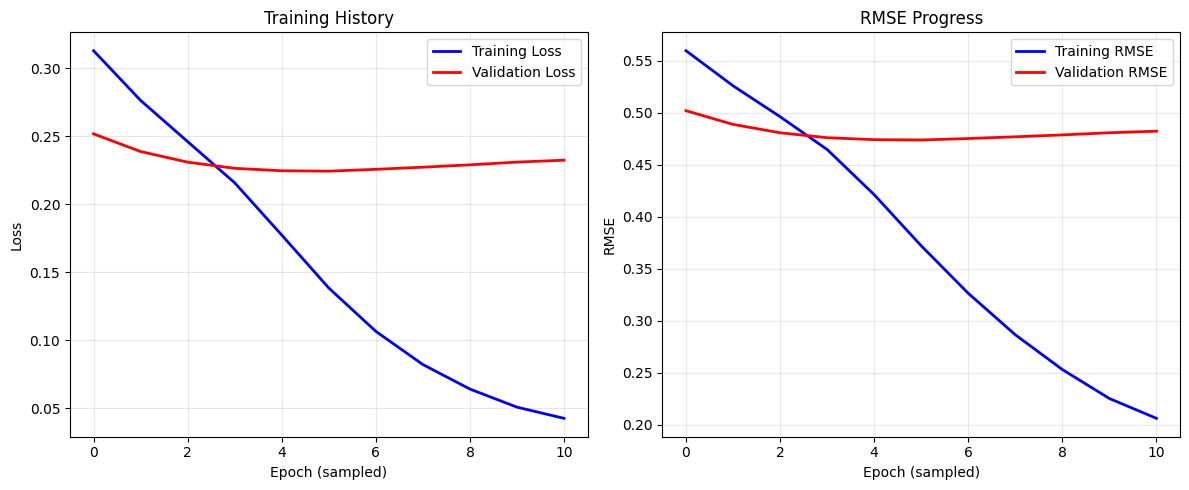

In [4]:
train_with_csv_data('../02.Dataset/reviews_300k.csv')